In [32]:
import sys
import csv
import os
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
import neuroml as nml
import neuroml.writers as writers
import random
import numpy
from IPython.display import clear_output
random.seed(12345)
def fix_measured(measured):
    meas_out = []
    for trace in measured:
        if trace == 'v':
            addend = 'v'
        elif trace == 'caConc':
            addend = 'caConc'
        elif trace == 'm':
            addend = 'biophys/membraneProperties/na_s_soma/na_s/m/q'
        elif trace == 'h':
            addend = 'biophys/membraneProperties/na_s_soma/na_s/h/q'
        elif trace == 'n':
            addend = 'biophys/membraneProperties/kdr_soma/kdr/n/q'
        elif trace == 'k':
            addend = 'biophys/membraneProperties/cal_soma/cal/k/q'
        elif trace == 'l':
            addend = 'biophys/membraneProperties/cal_soma/cal/l/q'
        elif trace == 'r':
            addend = 'biophys/membraneProperties/cah_dend/cah/r/q'
        elif trace == 'z':
            addend = 'biophys/membraneProperties/kca_dend/kca/z/q'
        elif trace == 'q':
            addend = 'biophys/membraneProperties/h_dend/h/n/q'
        else:
            print("Unknown measured quantity: "+trace)
            continue
        meas_out.append(addend)
    return meas_out

In [33]:
path = os.getcwd()
output_dict_nested = {}

start = 20
stop = 40
step = 0.1 #0.1
temp_range = np.arange(start, stop + step, step)
#temp_range = [37]
pulse = False #choose if you want to inject a pulse into the soma or not

clamps = [-70,-50,-30]

recordsegments = [0]

#Available cell NML files: C1A, C4A, C6A, C10, C11A, C15A, C16, C20A, C21A, C21B, C23, C25A, C25C, C28B, C31, C32B,
#C45A, C46A, C46B, C48, C49A, C49B, C49C, C50A, C50B, C51A, C51B, C51C, C51D. Not all of them are valid though.

cellSelection = ["C10", "C11A", "C21B", "C23", "C31", "C51A", "C51B"]
#cellSelection = ["C10"]

meas = ['v','caConc','m','h','n','k','l','r','z','q'] # Spiking detailed
#meas = ['v','caConc','k','l','z','q'] # STO detailed
meas = ['v'] # traces only

measC10 = ['v','caConc','m','h','n','k','l']
measC10 = ['v']
measC11A = meas
measC21B = meas
measC23 = meas
measC31 = meas
measC51A = meas
measC51B = meas

measjes = {}
measjes["C10"] = measC10
measjes["C11A"] = measC11A
measjes["C21B"] = measC21B
measjes["C23"] = measC23
measjes["C31"] = measC31
measjes["C51A"] = measC51A
measjes["C51B"] = measC51B



outputs = {} # will become a nested dictionary

for cellName in cellSelection:
    meas = measjes[cellName]
    measured = fix_measured(meas)
    print("Now running: " + cellName)
    output_dict = {}
    
    for i in temp_range:
        i = round(i,2)
        nml_doc = nml.NeuroMLDocument(id="net")

        #Include cell file
        incl = nml.IncludeType(href=cellName+"_scaled_exp_resample_5_relabel.cell.nml")
        nml_doc.includes.append(incl)

        #Create network
        net = nml.Network(id="net", type="networkWithTemperature", temperature=str(i)+"degC")
        nml_doc.networks.append(net)

        #Create population
        pop = nml.Population(id="pop", component=cellName, type="populationList", size="1")
        net.populations.append(pop)

        loc = nml.Location(x="0", y="0", z="0")

        inst = nml.Instance(id="0", location=loc)
        pop.instances.append(inst)

        
        #Create pulse generator
        t_delay = 0
        t_duration = 100
        t_rest = 900

        vc_1 = nml.VoltageClamp(id="vclamp1", 
                                delay=str(t_delay)+"ms", 
                                duration=str(t_duration)+"ms", 
                                target_voltage="-70mV",
                                simple_series_resistance="1ohm")
        nml_doc.voltage_clamps.append(vc_1)

        vc_2 = nml.VoltageClamp(id="vclamp2", 
                                delay=str(t_delay+(t_duration+t_rest)*1)+"ms", 
                                duration=str(t_duration)+"ms", 
                                target_voltage="-50mV",
                                simple_series_resistance="1ohm")
        nml_doc.voltage_clamps.append(vc_2)

        vc_3 = nml.VoltageClamp(id="vclamp3", 
                                delay=str(t_delay+(t_duration+t_rest)*2)+"ms", 
                                duration=str(t_duration)+"ms", 
                                target_voltage="-30mV",
                                simple_series_resistance="1ohm")
        nml_doc.voltage_clamps.append(vc_3)

        #Add pg to cell
        il = nml.InputList(id="clamps1", component=vc_1.id, populations="pop")
        ip = nml.Input(id="0", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
        il.input.append(ip)
        net.input_lists.append(il)

        il2 = nml.InputList(id="clamps2", component=vc_2.id, populations="pop")
        ip2 = nml.Input(id="1", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
        il2.input.append(ip2)
        net.input_lists.append(il2)

        il3 = nml.InputList(id="clamps3", component=vc_3.id, populations="pop")
        ip3 = nml.Input(id="2", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
        il3.input.append(ip3)
        net.input_lists.append(il3)

        nml_file = "nml_"+cellName+".net.nml"
        writers.NeuroMLWriter.write(nml_doc, nml_file)

        ref = "Test"
        sim_id = "Vm_%s"%ref
        sim_dur_ms = (t_duration+t_rest)*len(clamps)
        dt = 0.1
        #quantity = "pop/0/"+cellName+"/0/v"
        quantities = []
        for ss in recordsegments:
            for m in measured:
                q = "pop/0/"+cellName+"/"+str(ss)+"/"+m
                quantities.append(q)
        print(quantities)
        target = 'net'

        ls = LEMSSimulation(sim_id, sim_dur_ms, dt, target = target)
        ls.include_neuroml2_file("nml_"+cellName+".net.nml")

        disp0 = 'display0'
        ls.create_display(disp0, "Spiking pattern", "-90", "50")
        #ls.add_line_to_display(disp0, 'v', quantity)
    
        of0 = 'Volts_file'
        ls.create_output_file(of0, "%s.v.dat"%sim_id)
        #ls.add_column_to_output_file(of0, 'v', quantity)
        
        for q in range(0,len(quantities)):
            measnum = q % len(meas)
            ls.add_line_to_display(disp0,meas[measnum],quantities[q])
            ls.add_column_to_output_file(of0,meas[measnum],quantities[q])

        fn = "LEMS_%s.xml"%sim_id
        ls.save_to_file(file_name=fn)
   
        lems_file = path+'/LEMS_Vm_Test.xml'

        out_dir,rel_filename = os.path.split(lems_file)

        results_dict = pynml.run_lems_with_jneuroml_neuron(
            rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,
            max_memory='400M')
        
        '''
        if pulse:
            tLong = results_dict['t']
            vLong = results_dict[quantity]
            remove = int((t_delay + t_duration) // dt)
            results_dict['t'] = tLong[remove:]
            results_dict[quantity] = vLong[remove:]
        '''
    
        for quantity in quantities: 
            results_dict[str(quantity)+'.'+str(i)+'degC'] = results_dict.pop(quantity)
        output_dict.update(results_dict)
        
    if 't' in output_dict:
        t = output_dict.pop('t')
        
    if pulse:
        pepe = "pulse"
    else:
        pepe = "nopulse"
    
    for ss in recordsegments:
        for mmm in meas:
            mm = fix_measured([mmm])[0]
            quan = f"pop/0/{cellName}/{ss}/"+mm
            thisdat = {}
            for keykey in output_dict:
                if keykey.__contains__(quan):
                    templist = keykey.split('/')[-1].split('.')[1:]
                    temp = ''
                    for item in templist:
                        if item == templist[0]:
                            temp = temp + item
                        else:
                            temp = temp + '.' + item
                    thisdat[temp]=output_dict[keykey]
            dd = pd.DataFrame(thisdat,index = t)
            dd = pd.DataFrame.transpose(dd)
            dd.to_csv(f"{cellName}_{ss}_{start}to{stop}_step{step}_{mmm}_clamps.csv")

    df = pd.DataFrame(output_dict, index = t)
    df = pd.DataFrame.transpose(df)
    df.to_csv(f"{cellName}_{start}to{stop}_step{step}_all.csv")
    
    outputs[cellName] = output_dict
    clear_output(wait=True)

Now running: C51B
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_of

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
['pop/0/C51B/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/

Plotted cell: C10


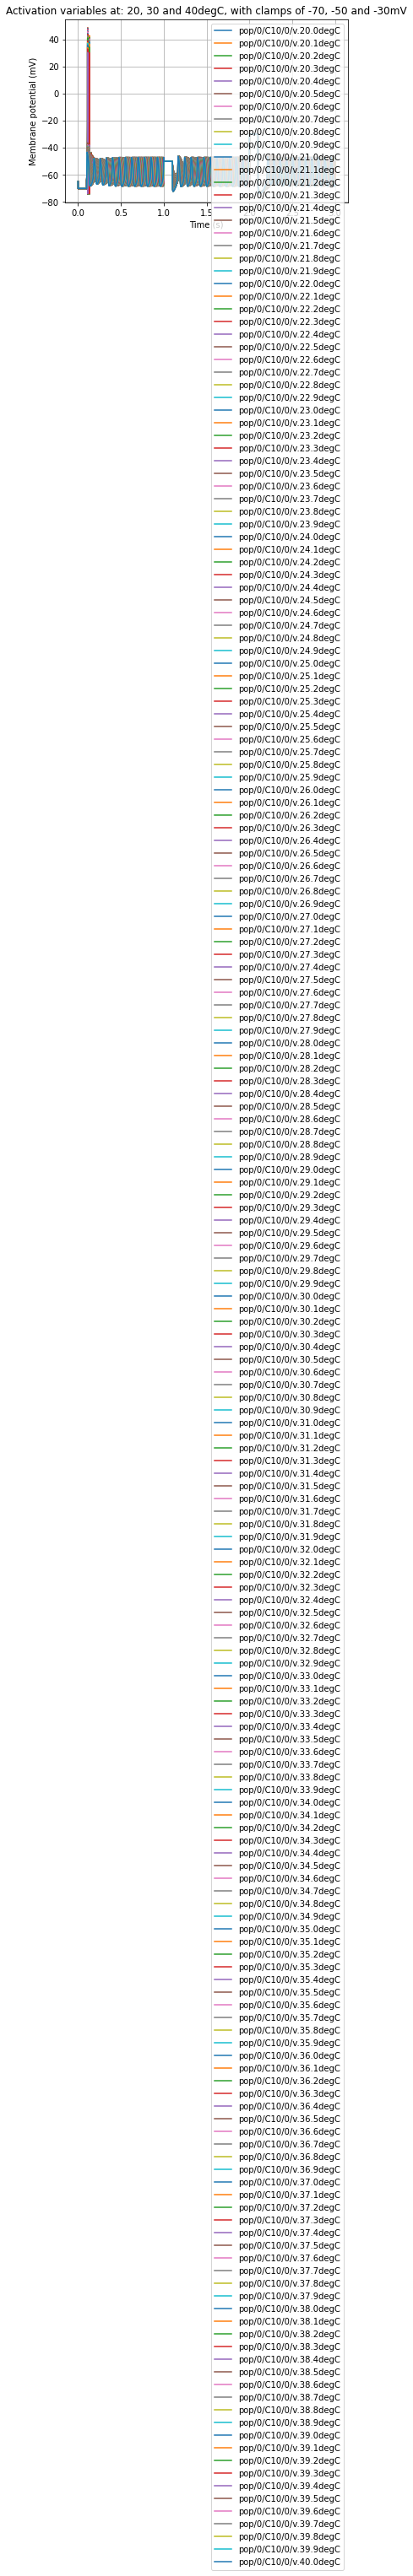


----------------------------------------------------------------------

Plotted cell: C11A


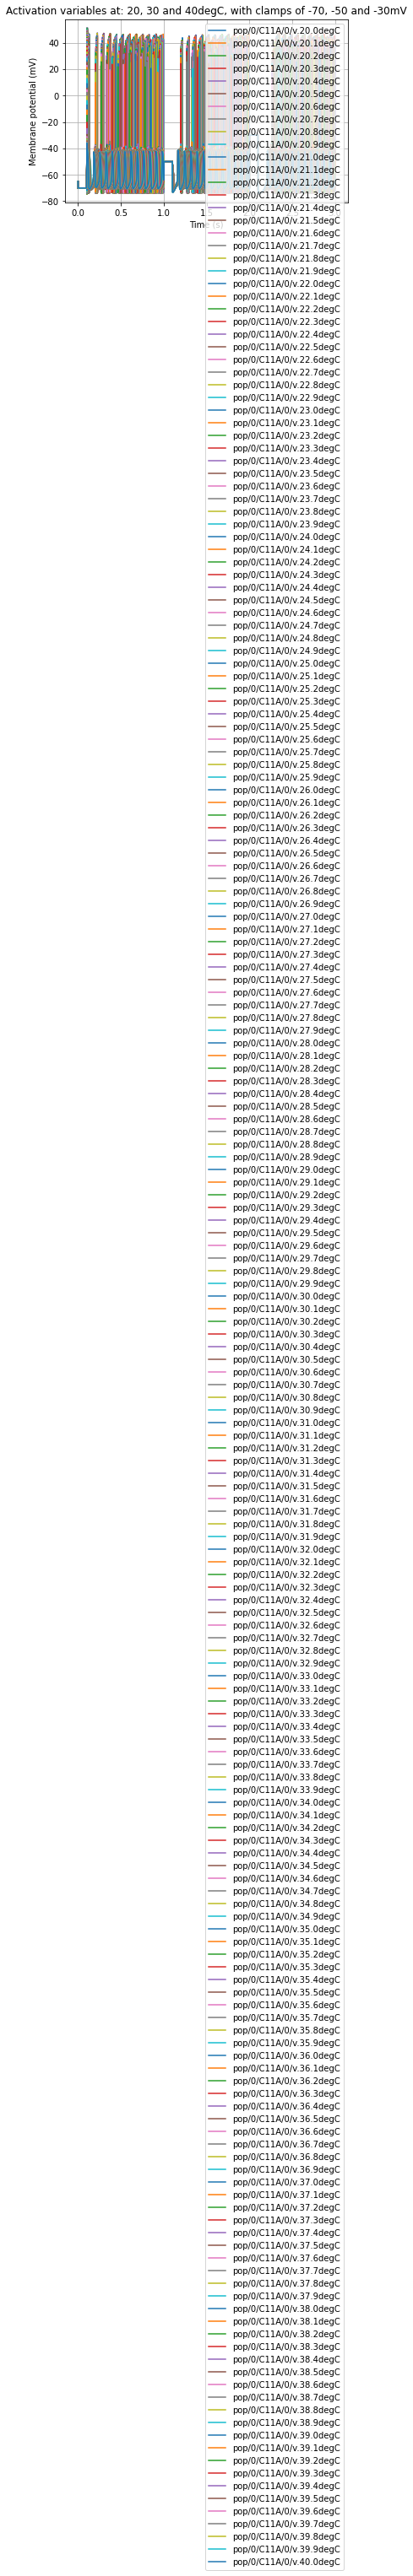


----------------------------------------------------------------------

Plotted cell: C21B


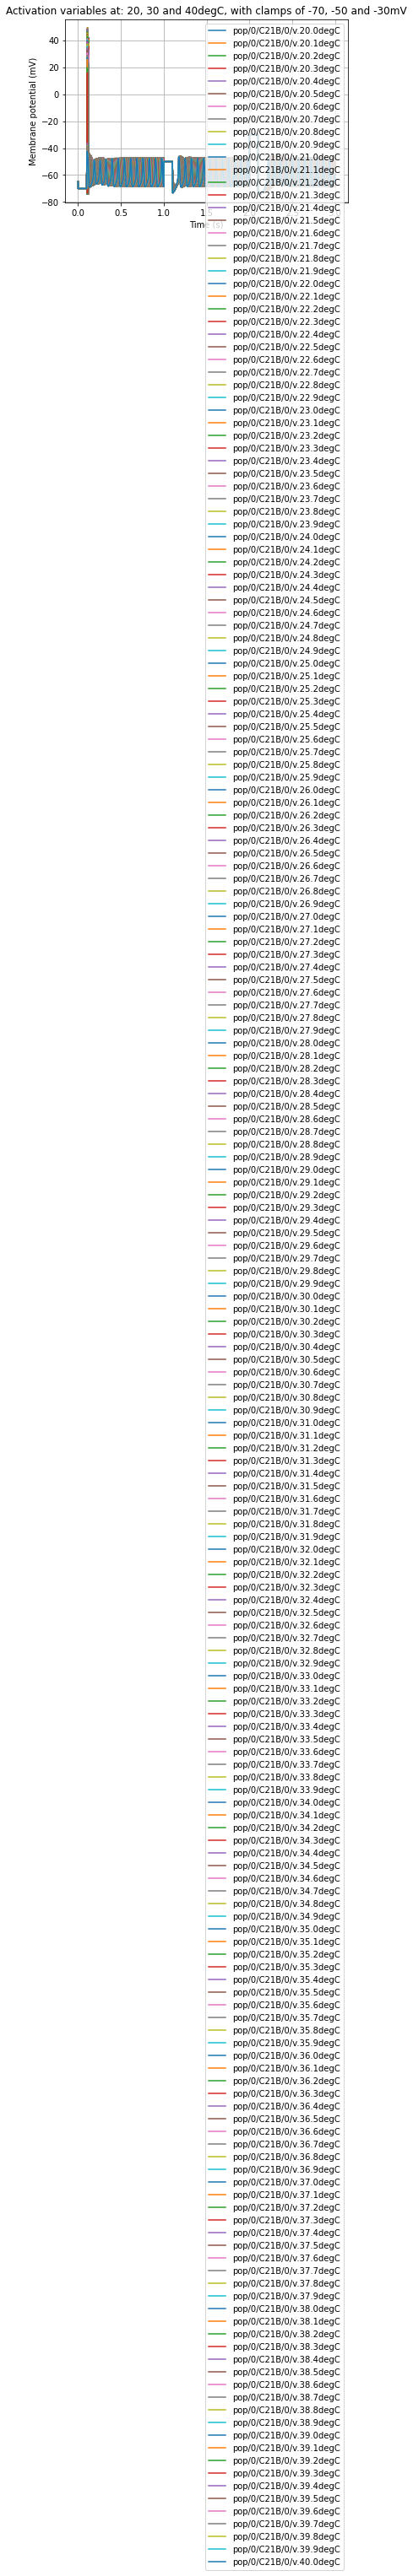


----------------------------------------------------------------------

Plotted cell: C23


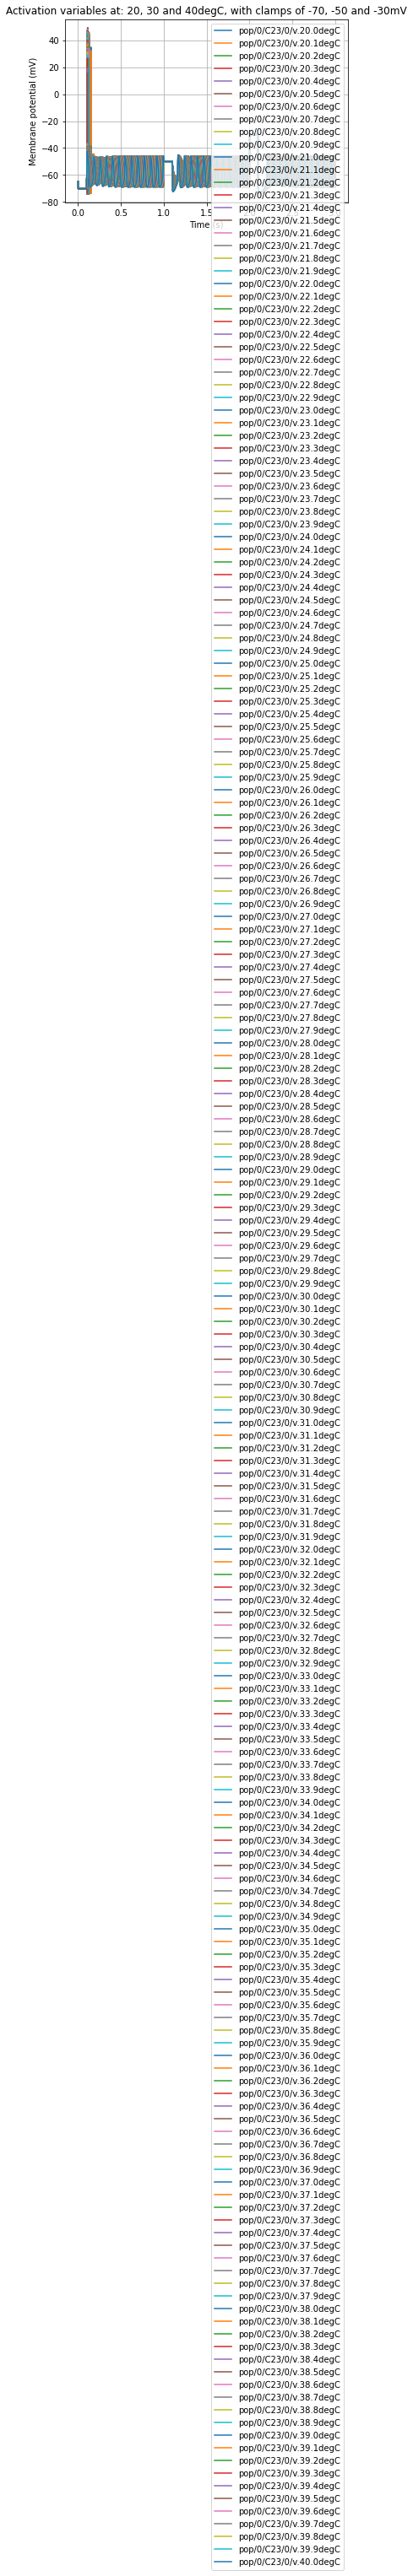


----------------------------------------------------------------------

Plotted cell: C31


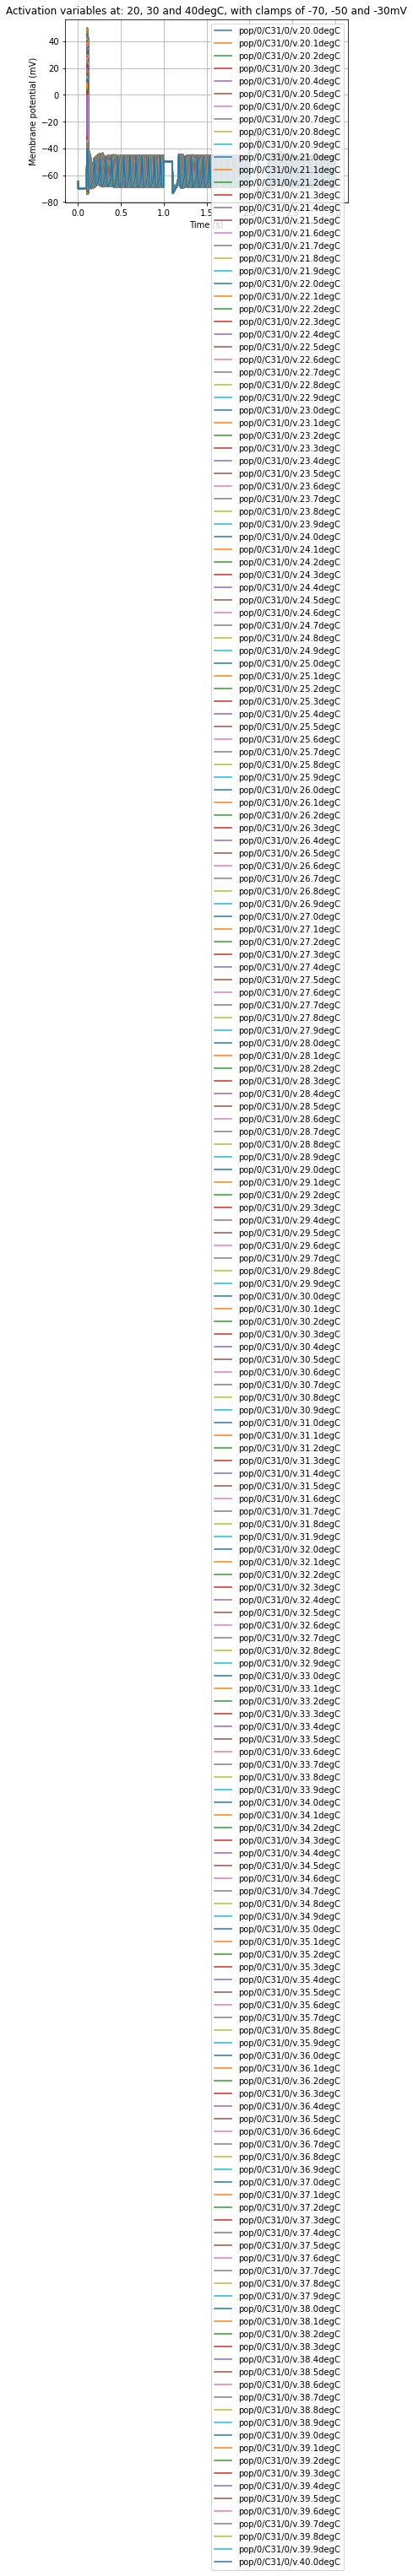


----------------------------------------------------------------------

Plotted cell: C51A


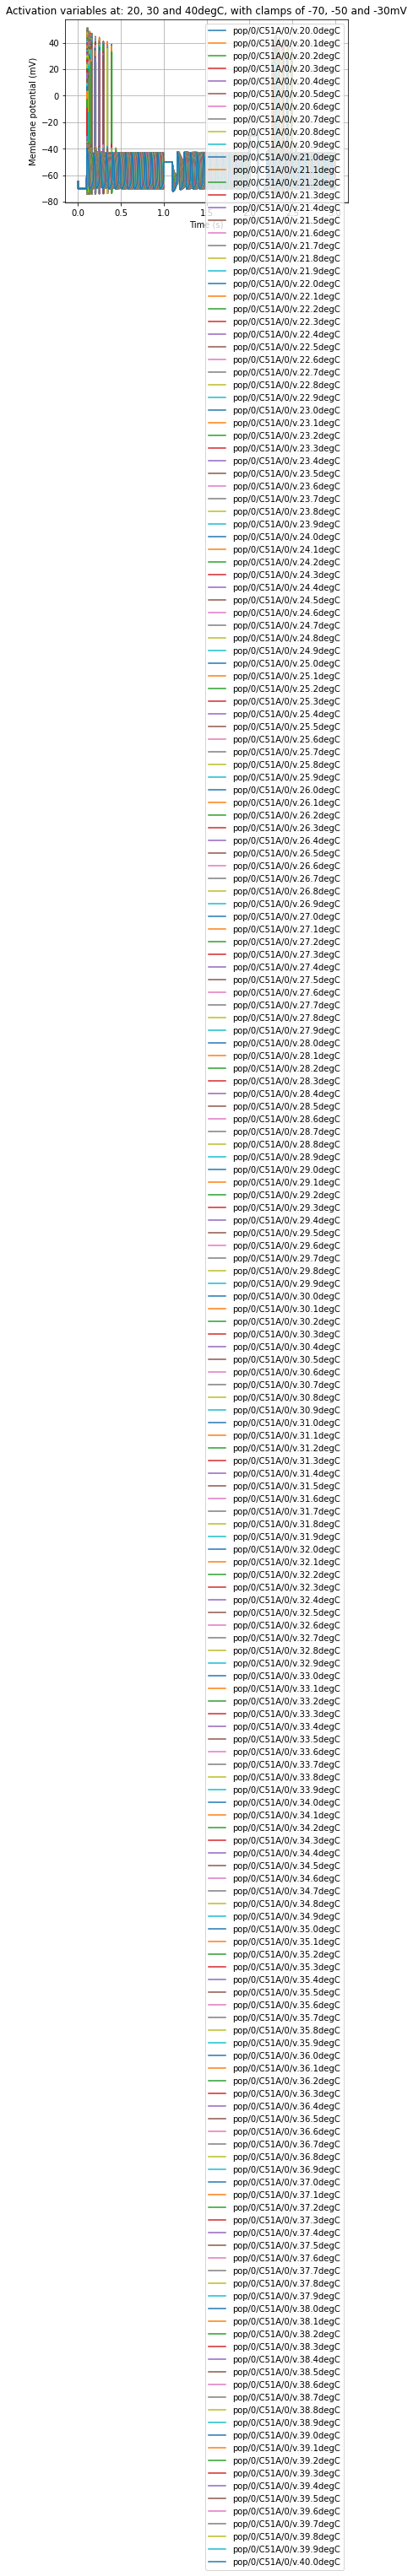


----------------------------------------------------------------------

Plotted cell: C51B


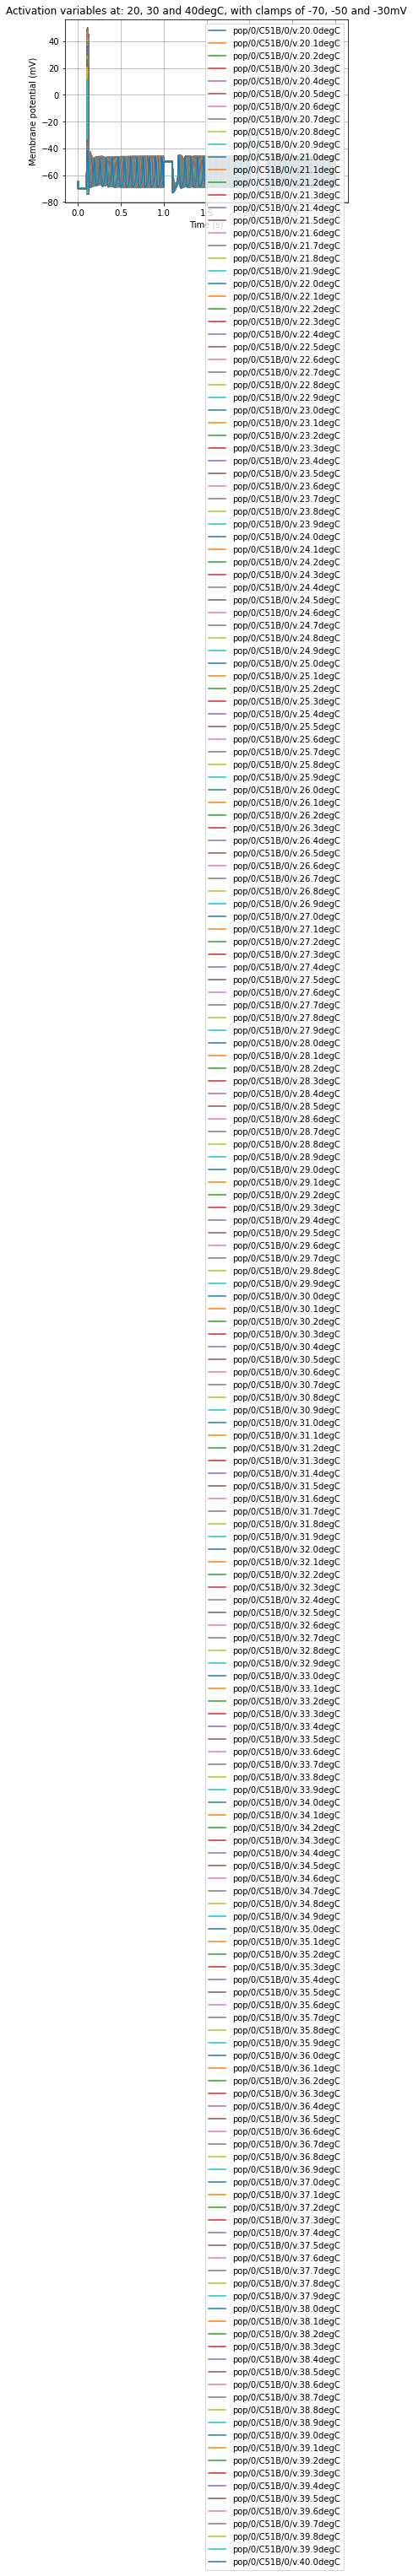


----------------------------------------------------------------------



In [34]:
# Plot every cell apart (I could make a 'plot every temperature apart')

import matplotlib
import matplotlib.pyplot as plt

def correct_data(t,toplot,tP):
    if tP:
        return [t,toplot]
    else:
        return[t[2000:],toplot[2000:]]

transientPlotting = True

for cellName in outputs:
    print(f"Plotted cell: {cellName}")
    output_dict = outputs[cellName]
    
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane potential (mV)')
    plt.grid(True)

    plotting_AV = False
    AVs = []
    caConc_plotting = False
    cas = []
    for key in output_dict:
        if key == 't':
            # no need to plot sim time against sim time
            continue
        elif key.__contains__('v.'):
            toplot = [x*1000 for x in output_dict[key]]
            newt,toplot = correct_data(t,toplot,transientPlotting)
            plt.plot(newt, toplot, label=""+key)
        elif key.__contains__('caConc.'):
            caConc_plotting = True
            cas.append(key)
        else:
            plotting_AV = True
            AVs.append((key))

    plt.legend(loc='upper right')
    plt.title(f"Activation variables at: 20, 30 and 40degC, with clamps of -70, -50 and -30mV")
    plt.show()
    
    if caConc_plotting:
        plt.xlabel('Time (s)')
        plt.ylabel('Calcium concentration ()')
        plt.grid(True)
        
        for cc in cas:
            toplot = output_dict[cc]
            newt,toplot = correct_data(t,toplot,transientPlotting)
            labl = cc.split('/')[-1]
            plt.plot(newt,toplot,label=""+labl)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
        plt.title("Calcium concentrations")
        plt.show()
    
    if plotting_AV:
        for ttt in temp_range:
            plt.xlabel('Time (s)')
            plt.ylabel('Activation quotient')
            plt.grid(True)

            for av in AVs:
                if not av.__contains__(str(ttt)):
                    continue
                toplot = output_dict[av]
                newt,toplot = correct_data(t,toplot,transientPlotting)
                labl = av.split('/')[-2]+'/'+av.split('/')[-1]
                plt.plot(newt,toplot,label=""+labl)
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
            plt.title(f"Activation variables at: 20, 30 and 40degC, with clamps of -70, -50 and -30mV")
            plt.show()
        
    print("\n----------------------------------------------------------------------\n")


Plotted cell: C10


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C10_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C11A


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C11A_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C21B


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C21B_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C23


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C23_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C31


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C31_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C51A


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C51A_20to40_step0.1.mp4



----------------------------------------------------------------------

Plotted cell: C51B


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ClampAnimation_C51B_20to40_step0.1.mp4



----------------------------------------------------------------------



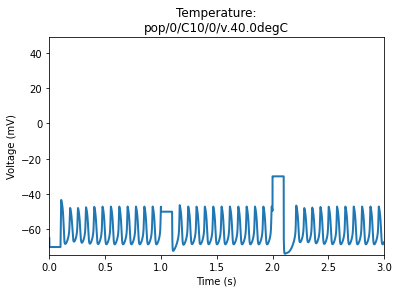

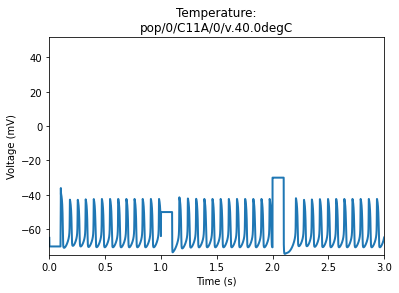

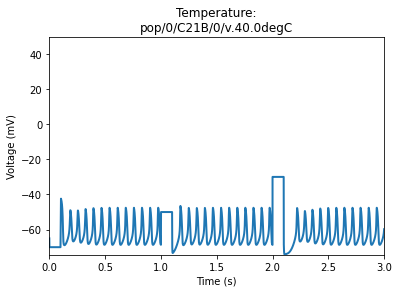

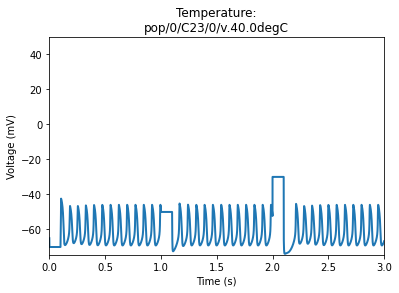

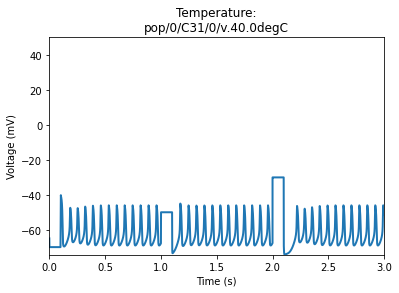

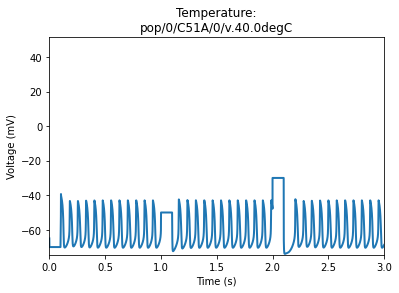

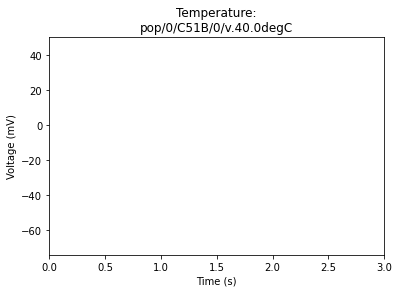

In [35]:
# Animate above plots into animations over Temperature!

from matplotlib.animation import FuncAnimation

def init():
    plotjeh.set_data([],[])
    ax.set_xlim([0,t[-1]])
    ax.set_ylim([minx*1000,maxx*1000])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (mV)")
    return plotjeh,
    

def animation_func(tempnum):
    #print(t)
    temp = round(temp_range[tempnum],2)
    # print(temp)
    key = "pop/0/"+cellName+"/0/v."+str(temp)+'degC'
    output = output_dict[key]
    toplot = [x*1000 for x in output]
    ax.set_title("Temperature:\n"+key)
    plotjeh.set_data(np.array(t),np.array(toplot))
    return plotjeh,

plotAll = True
plotOne = 'C21B'
# print(temp_range)

if plotAll:
    for cellName in outputs:
        print(f"Plotted cell: {cellName}")
        output_dict = outputs[cellName]
        tpresent = False
        maxx = -99999
        minx = 99999
        for key in output_dict:
            if key == 't':
                tpresent = True
            else:
                if max(output_dict[key]) > maxx:
                    maxx = max(output_dict[key])
                if min(output_dict[key]) < minx:
                    minx = min(output_dict[key])
        if maxx > 0.15:
            maxx = 0.15
        if minx < -0.15:
            minx = 0.15
        if tpresent:
            del output_dict['t']
        
        fig = plt.figure()
        ax = plt.axes()
        plotjeh, = ax.plot([],[],lw=2)    
        anim = FuncAnimation(fig,animation_func,frames=len(output_dict),interval=100,init_func=init)
        # plt.show()
        anim.save(f"ClampAnimation_{cellName}_{start}to{stop}_step{step}.mp4",writer='ffmpeg', fps=30)
        print("\n----------------------------------------------------------------------\n")
else:
    print(f"Plotted cell: {plotOne}")
    output_dict = outputs[plotOne]
    tpresent = False
    maxx = -99999
    minx = 99999
    for key in output_dict:
        if key == 't':
            tpresent = True
        else:
            if max(output_dict[key]) > maxx:
                maxx = max(output_dict[key])
            if min(output_dict[key]) < minx:
                minx = min(output_dict[key])
    if tpresent:
        del output_dict['t']
    
    fig = plt.figure()
    ax = plt.axes()
    plotjeh, = ax.plot([],[],lw=2)
    anim = FuncAnimation(fig,animation_func,frames=len(output_dict),interval=100,init_func=init)
    #plt.show()
    anim.save(f"TempAnimation_{cellName}_{start}to{stop}_step{step}.mp4",writer='ffmpeg', fps=30)
    print("\n----------------------------------------------------------------------\n")